# Часть 1: Предобработка данных 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sea

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sea.set_style("darkgrid")

In [35]:
data = pd.read_csv("/Users/mariamitrankova/Downloads/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "80px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

/var/folders/6r/tphhr3f17_9gplh9_dcrhzk40000gn/T/ipykernel_45109/3785507735.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.head(10).style.set_precision(2). \


Таргет - колонка churn - пользователи, которые покинули оператора за последний месяц

In [36]:
# customerID можно удалить, не влияет на предсказание
data.drop("customerID", axis=1, inplace=True)

In [37]:
data_X = data.loc[:, data.columns != "Churn"]
data_Y = data[["Churn"]]

print("\ndata_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()


data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-

## Feature Engineering

In [38]:
for c in data_X.columns:
    
    print("Feature name: {}".format(c))
    print("Unique values:\n")
    print(data_X[c].unique())
    print("\n--------------------------------------------------\n")

Feature name: gender
Unique values:

['Female' 'Male']

--------------------------------------------------

Feature name: SeniorCitizen
Unique values:

[0 1]

--------------------------------------------------

Feature name: Partner
Unique values:

['Yes' 'No']

--------------------------------------------------

Feature name: Dependents
Unique values:

['No' 'Yes']

--------------------------------------------------

Feature name: tenure
Unique values:

[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

--------------------------------------------------

Feature name: PhoneService
Unique values:

['No' 'Yes']

--------------------------------------------------

Feature name: MultipleLines
Unique values:

['No phone service' 'No' 'Yes']

--------------------------------------------------

Feature name: InternetServ

Для Total Charges удаляем пробелы и переводим во float.

In [39]:
for row in range(len(data_X)):
    data_X.loc[row, "TotalCharges"] = data_X.loc[row, "TotalCharges"].replace(" ", "")
    data_X.loc[row, "TotalCharges"] = pd.to_numeric(data_X.loc[row, "TotalCharges"])

Если пропусков немного, то наблюдения можно удалить. Мы заменим пропуски средним значением фичи.

In [40]:
mean_ = data_X["TotalCharges"].mean()
data_X = data_X.fillna({"TotalCharges": mean_})

Выделим числовые и категориальные фичи:

In [41]:
cat = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
       "MultipleLines", "InternetService", "OnlineSecurity",
       "OnlineBackup", "DeviceProtection", "TechSupport",
       "StreamingTV", "StreamingMovies", "Contract",
       "PaperlessBilling", "PaymentMethod"]

num = ["tenure", "MonthlyCharges", "TotalCharges"]

К категориальным фичам можно применить OneHotEncoding

In [42]:
enc = OneHotEncoder(drop="first")
enc.fit(data_X[cat]);

cat2 = enc.get_feature_names_out(cat)
data_X_C = pd.DataFrame(enc.transform(data_X[cat]).toarray(),
                        columns = cat2)

Склеим числовые и закодированные категориальные фичи в один датасет

In [43]:
data_X = pd.concat([data_X_C, data_X[num]], axis=1)

Названия фичей выглядят так:

In [44]:
feature_names = data_X.columns
print(feature_names)

Index(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


Посмотрим на значения таргета:

In [45]:
data_Y["Churn"].unique()

array(['No', 'Yes'], dtype=object)

Переведем в бинарный формат

In [46]:
data_Y = data_Y.assign(Churn=lambda x: (x == "Yes").astype(int))

In [86]:
# lb = LabelBinarizer()

# lb.fit(data_Y["Churn"]);
# data_Y["Churn"] = lb.transform(data_Y["Churn"])
# data_Y["Churn"]

Разобьем данные на обучающие и тестовые.

In [47]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    shuffle = True,
                                                    stratify=data_Y, # сохраняем пропорцию классов на трейне и тесте
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

## Стандартизация

Параметры стандартизации нужно получать только на тренировочных данных, чтобы избежать утечки информации на тесте.

In [49]:
scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

In [52]:
train_Y = train_Y.values.ravel() # prepare for sklearn classifiers

## Часть 2. Основные метрики качества классификации

### Матрица ошибок


Существует множество различных числовых характеристик, позволяющих измерить качество бинарного классификатора. В случае двух классов возможны всего 4 исхода при классификации данного объекта. Их удобно отображать с помощью матрицы ошибок (confusion matrix).Это таблица с двумя строками и двумя столбцами, в ячейках которой указаны следующие значения:
* $TP=$ число верно классифицированных положительных примеров
* $FP=$ число отрицательных примеров, классифицированных положительно (ошибки первого рода)
* $TN=$ число верно классифицированных отрицательных примеров
* $FN=$ число положительных примеров, классифицированных отрицательно (ошибки второго рода)

Получить такую таблицу можно с помощью функции `sklearn.metrics.confusion_matrix`, передав ей на вход истинные и предсказанные классификатором метки.

In [74]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn import metrics

base_knn_cls = KNeighborsClassifier(n_neighbors=1)
base_knn_cls.fit(train_X, train_Y)
predicted_labels = base_knn_cls.predict(test_X)
M = metrics.confusion_matrix(test_Y, predicted_labels)
M #/len(test_Y)

array([[0.58977999, 0.14478353],
       [0.1376863 , 0.12775018]])

### Характеристики бинарного классификатора

Основываясь на данной таблице, можно ввести несколько величин, характеризующих бинарный классификатор:
* $recall=TPR=\frac{TP}{TP+FN}$ - доля верно классифицированных положительных примеров среди всех положительных примеров.
* $precision=\frac{TP}{TP+FP}$ - доля верно классифицированных положительных примеров среди всех примеров, классифицированных положительно.
* $FPR=\frac{FP}{FP+TN}$ - доля ошибочно классифицированных отрицательных примеров среди всех отрицательных примеров.
* $accuracy=\frac{TP+TN}{TP+TN+FP+FN}$ - доля верно классифицированных примеров среди всех примеров. Основная характеристика качества классификации.
* $F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$ - среднее гармоническое точности и полноты. Позволяет учесть обе характеристики одновременно.

In [75]:
PPV = metrics.precision_score(test_Y, predicted_labels)
TPR = metrics.recall_score(test_Y, predicted_labels)
F1 = metrics.f1_score(test_Y, predicted_labels)
ACC = metrics.accuracy_score(test_Y, predicted_labels)
PPV, TPR, F1, ACC

(0.46875, 0.48128342245989303, 0.474934036939314, 0.7175301632363378)

### ROC-кривая и AUC

ROC-кривая (Receiver Operating Characteristic) - это графическая характеристика качества бинарного классификатора, выражающая зависимость TPR от FPR при варьировании порога решающего правила. Она наглядно представляет, каким будет качество классификации при различных значениях порога.

Площадь под ROC-кривой AUC (Area Under Curve) является количественной характеристикой качества классификации, не зависящей от соотношения цен ошибок. Чем больше значение AUC, тем «лучше» модель классификации.

### Случай дисбаланса классов 

Возможные действия:
* Использовать метрики типа F1, ROC AUC, а не accuracy
* Использовать метрику, в которой ошибка на объекте из редкого класса входит с большим весом, чем ошибка на объекте из частого класса
* Применять oversampling и undersampling. В первом случае в выборку добавляются представители редкого класса (сэмплируются с замещением). Во втором - представители частого класса случайным образом удаляются из выборки
* ...

In [70]:
import sys

from sklearn.svm import SVC, LinearSVC

if sys.version_info.major == 2:
    from urllib import urlopen
elif sys.version_info.major == 3:
    from urllib.request import urlopen

from sklearn import datasets
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

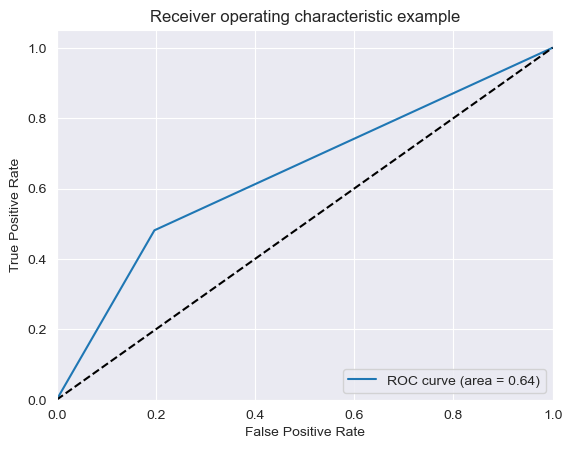

In [79]:
y_score = base_knn_cls.predict_proba(test_X)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_Y, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## Подбор гиперпараметров в kNN с помощью GridSearch и кросс-валидации

Указанные выше характеристики можно использовать для подбора параметров алгоритмов, например, с помощью кросс-валидации. Найдём оптимальное с точки зрения F1-меры число ближайших соседей в алгоритме kNN.



In [80]:
knn_cls = KNeighborsClassifier()
parameters = {
    "n_neighbors": range(30, 50, 2),
    "metric": ["minkowski"],
    "p": [1.0, 2.0],
    "algorithm": ["brute"]
}

skf_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
gscv = GridSearchCV(
    estimator=knn_cls,
    param_grid=parameters,
    scoring="f1",
    n_jobs=-1, # better to put -2 on local machine
    cv=skf_cv,
    verbose=False
)

gscv.fit(train_X, train_Y)
print("Best parameters {}".format(gscv.best_params_))

Best parameters {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 44, 'p': 1.0}


По умолчанию у GridSearchCV указан параметр `refit=True`, при котором лучший классификатор обучается заново на всем датасете.

In [81]:
knn_cls = gscv.best_estimator_ # classifier with best params

In [82]:
y_pred = knn_cls.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=["Churn No", "Churn Yes"]))

              precision    recall  f1-score   support

    Churn No       0.85      0.88      0.87      1035
   Churn Yes       0.64      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.80      0.80      1409



kNN с KD-деревом 

In [83]:
knn_cls = KNeighborsClassifier()
parameters = {
    "n_neighbors": range(40, 60, 2),
    "leaf_size": [1, 2, 3],
    "metric": ["minkowski"],
    "p": [1.0, 2.0],
    "algorithm": ["kd_tree"]
}

skf_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
gscv = GridSearchCV(
    estimator=knn_cls,
    param_grid=parameters,
    scoring="f1",
    n_jobs=-1,
    cv=skf_cv,
    verbose=False
)

gscv.fit(train_X, train_Y)
print("Best parameters {}".format(gscv.best_params_))

Best parameters {'algorithm': 'kd_tree', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 44, 'p': 1.0}


In [84]:
kd_knn_cls = gscv.best_estimator_
kd_knn_cls.fit(train_X, train_Y)
y_pred = kd_knn_cls.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=["Churn No", "Churn Yes"]))

              precision    recall  f1-score   support

    Churn No       0.85      0.88      0.87      1035
   Churn Yes       0.64      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.80      0.80      1409



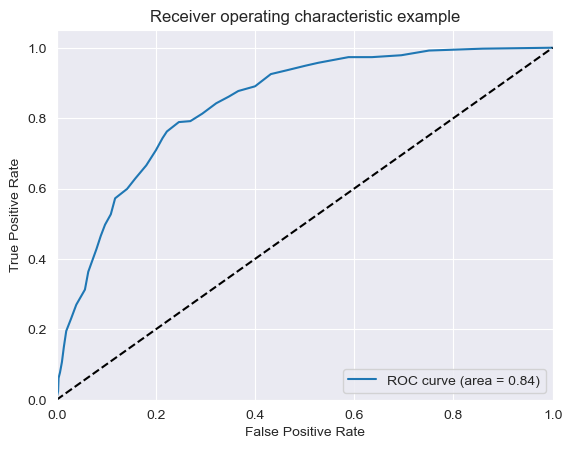

In [85]:
y_score = kd_knn_cls.predict_proba(test_X)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_Y, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()